Copyright 2020 Abhishek Dabas

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CO

## Abstract:
In this notebook we will try to understand the Actor Critic Method, which is considered a mix of Policy Based and Vlue based networks. Both of these(Value based and policy based networks) have some drawbacks, where comes a new method, which is acctually a hybrid method called "**Actor Critic Method**". In this notebook we will try to go through this new Method and try to implement it in one of the Gym Environment.

# Policy Based Methods:
**Policy:** A policy is defined as the probability distribution of actions given a state
$$P(A|S)$$
In Policy-based, there is not need to learn a value function. It select an action without using a value fuction. In this method we directly try to optimze the value function $\pi$ .
- $\pi$ is the probability distribution of the actions
$$\pi_\theta(a|s) = P(a|s)$$

## Advantages:
- They have ``better convergence properties.`` Value based methods oscilate alot. In policy based methods we follow a bepolicy gradient, to find the best parameters. Because we follow the gradient here, we are guaranteed to converge with the local maximum or global maximum. 
- Policy based methods are ``better in high dimensional action spaces.`` When there is continuous action spaces, they work better. In DQN we try to assign a score to the definte action, at each time step, but when the action space is continuous, this becomes very complicated, ex driving a car, where the angle of the wheel 15,15.1, 15.2 etc are possibilities. Policy methods adjust the parameters directly. 
- Policy based methods can ``learn stochastic policy``. We dont need to implement the exploration/exploitation tradeoff, in this. In stochastic policy the agent explored the state space without always taking the same action. The output space here is a probability distribution over actions. 
## Disadvantages:
- They take ``alot of time to converge, often getting stuck on the local maximum rather than global optimum. `` They take slow step by step
- ``Evaluating a policy is inefficient and has high variance``
## Check if the policy is Good or Not
TTo measure how good a policy is we use a function called,`` Objective function`` that calculates the expected reward tof the policy. In Policy based methods we are trying to optimize the best parameters($\theta$). $J\theta$ will tell us how good the policy is and the policy ascent will help us find the best policy parameters to maximize the good actions
$$J(\theta) = E_(\pi\theta) [\sum \gamma r]$$
- we want to check the quality of the policy $\pi$ with a score function $J(\theta)$
- Use policy gradient ascent to find the best parameters $\theta$ that improves $\pi$
### Policy gradient Ascent 
Once we know how good our policy is, we want to maximize the parameters $\theta$ that maximizes the score function. Maximizing this score function means finding the optimal policy.  Now, for maximizing this score function $J(\theta)$, we do gradient ascent on policy parameters. Gradient ascent is just the inverse of gradient descent. In gradient ascent we take the direction of the steepest ascent. We want to find the gradient to the current policy $\pi$ that updates the parameters in the direction of greatest increase, and then iterate. 
$$Policy : \pi_\theta$$
$$Pbjective function : J(\theta)$$
$$Gradient : \triangledown_\theta J(\theta)$$
$$Update : \theta \leftarrow \theta + \alpha \triangledown_\theta J(\theta)$$
we want to find the policy that maximizes the score:
$$\theta^* = argmax J(\theta) =  argmax E_(\pi \theta) [\sum R(s_t,a_t]$$
which is the total summation of expected rewar given policy. So we want to differenciate the sore function $J(\theta)$
- Example: [Cartpole](https://github.com/simoninithomas/Deep_reinforcement_learning_Course/blob/master/Policy%20Gradients/Cartpole/Cartpole%20REINFORCE%20Monte%20Carlo%20Policy%20Gradients.ipynb)

<img src= "images/epolicy.png">

- Value based: Here we learn a value function that maps a state to a action. It is useful when we have finite action space. 
- Policy Based: Here we directly try to learn the optimal policy using the value function. It is useful when we have a coninuous or stochastic actions. 
# Actor Critic Method
A hybrid between value-based algorithms and policy based algorithms

### what is Actor and Critic 
1. The **Critic** estimates the value function. Which could be either an action-value (Q-value) or a State-value(Value)
$$ q\hat (s,a,w) $$
1. The **Actor** updates the policy distribution i the direction suggested by the critic, which is the policy gradients
$$\pi(s,a,\theta)$$
As we can see here we have 2 neural networks here!!
> Both Actor and Critic functions are parametrized with neural networks.

## Imports

In [2]:
import gym
import numpy as np 
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers.merge import Add, Multiply
from keras.optimizers import Adam
import keras.backend as K

import tensorflow as tf

import random
from collections import deque

### Creating the ActorCritic Class
- Chain rule: find the gradient of chaging the actor network params in  #
- getting closest to the final value network predictions, i.e. de/dA    #
- Calculate de/dA as = de/dC * dC/dA, where e is error, C critic, A act 

In [3]:
class ActorCritic:
    def __init__(self, env, sess):
        self.env  = env
        self.sess = sess

        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = .995
        self.gamma = .95
        self.tau   = .125


        self.memory = deque(maxlen=2000)
        self.actor_state_input, self.actor_model = self.create_actor_model()
        _, self.target_actor_model = self.create_actor_model()
        
 # this is where we will feed from critic

        self.actor_critic_grad = tf.placeholder(tf.float32, 
            [None, self.env.action_space.shape[0]])

        actor_model_weights = self.actor_model.trainable_weights
        self.actor_grads = tf.gradients(self.actor_model.output, 
            actor_model_weights, -self.actor_critic_grad) # dC/dA (from actor)
        grads = zip(self.actor_grads, actor_model_weights)
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(grads)

##the critic model will help us check the perfoamnce by actor

        self.critic_state_input, self.critic_action_input, \
            self.critic_model = self.create_critic_model()
        _, _, self.target_critic_model = self.create_critic_model()

        self.critic_grads = tf.gradients(self.critic_model.output, 
            self.critic_action_input) # where we calcaulte de/dC for feeding above

        # Initialize for later gradient calculations
        self.sess.run(tf.initialize_all_variables())

## Model definations


    # actor model
    ## In a current state what is the best action
    def create_actor_model(self):
        state_input = Input(shape=self.env.observation_space.shape)
        h1 = Dense(24, activation='relu')(state_input)
        h2 = Dense(48, activation='relu')(h1)
        h3 = Dense(24, activation='relu')(h2)
        output = Dense(self.env.action_space.shape[0], activation='relu')(h3)

        model = Model(input=state_input, output=output)
        adam  = Adam(lr=0.001)
        model.compile(loss="mse", optimizer=adam)
        return state_input, model

    # critic model
    # the q scores are calculated seperately in the critic model 
    # It input the action space and state space, and outputs the value
    def create_critic_model(self):
        state_input = Input(shape=self.env.observation_space.shape)
        state_h1 = Dense(24, activation='relu')(state_input)
        state_h2 = Dense(48)(state_h1)

        action_input = Input(shape=self.env.action_space.shape)
        action_h1    = Dense(48)(action_input)
        
        # a layer in the middle to merge the two
        merged    = Add()([state_h2, action_h1])
        merged_h1 = Dense(24, activation='relu')(merged)
        output = Dense(1, activation='relu')(merged_h1)
        model  = Model(input=[state_input,action_input], output=output)

        adam  = Adam(lr=0.001)
        model.compile(loss="mse", optimizer=adam)
        return state_input, action_input, model

# Model Training
# the updates are happenening at every time step

    # this is our memory
    def remember(self, cur_state, action, reward, new_state, done):
        self.memory.append([cur_state, action, reward, new_state, done])

        ## lets trainig the actor
    def _train_actor(self, samples):
        for sample in samples:
            cur_state, action, reward, new_state, _ = sample
            predicted_action = self.actor_model.predict(cur_state)
            grads = self.sess.run(self.critic_grads, feed_dict={
                self.critic_state_input:  cur_state,
                self.critic_action_input: predicted_action
            })[0]

            self.sess.run(self.optimize, feed_dict={
                self.actor_state_input: cur_state,
                self.actor_critic_grad: grads
            })

    ## lets trainig the critic 
    def _train_critic(self, samples):
        for sample in samples:
            cur_state, action, reward, new_state, done = sample
            if not done:
                target_action = self.target_actor_model.predict(new_state)
                future_reward = self.target_critic_model.predict(
                    [new_state, target_action])[0][0]
                reward += self.gamma * future_reward
            self.critic_model.fit([cur_state, action], reward, verbose=0)

    def train(self):
        batch_size = 32
        if len(self.memory) < batch_size:
            return

        rewards = []
        samples = random.sample(self.memory, batch_size)
        self._train_critic(samples)
        self._train_actor(samples)

## Target Model Updating 
##  we want to determine what change in parameters (in the actor model) 
##  would result in the largest increase in the Q value (predicted by the critic model)

    def _update_actor_target(self):
        actor_model_weights  = self.actor_model.get_weights()
        actor_target_weights = self.target_critic_model.get_weights()

        for i in range(len(actor_target_weights)):
            actor_target_weights[i] = actor_model_weights[i]
        self.target_critic_model.set_weights(actor_target_weights)

    def _update_critic_target(self):
        critic_model_weights  = self.critic_model.get_weights()
        critic_target_weights = self.critic_target_model.get_weights()

        for i in range(len(critic_target_weights)):
            critic_target_weights[i] = critic_model_weights[i]
        self.critic_target_model.set_weights(critic_target_weights)

    def update_target(self):
        self._update_actor_target()
        self._update_critic_target()

## Model predictions
    # similar to DQN 
    def act(self, cur_state):
        self.epsilon *= self.epsilon_decay
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return self.actor_model.predict(cur_state)


### Environment
We will be using it in the OpenAI Gym's **Pendulum-V0** environment.
- The inverted pendulum swingup problem is a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright.
- The pendulum Env has a infinite input space!! the number of action space in inf!!

In [ ]:
# determines how to assign values to each state, i.e. takes the state
# and action (two-input model) and determines the corresponding value

## storing results

def main():
    sess = tf.Session()
    K.set_session(sess)
    env = gym.make("Pendulum-v0")
    actor_critic = ActorCritic(env, sess)
    
    # Hyper parameters
    num_trials = 10000
    trial_len  = 500
    
    reward_global = []
    
    for i in range(num_trials):
            cur_state = env.reset()

#             env.render()
            
            # start with sample random action
            action = env.action_space.sample()
            
            # current state 
            cur_state = cur_state.reshape((1, env.observation_space.shape[0]))
            
            rewards_trial=0
                
            for j in range(trial_len):
                # the acord learn the steps
                action = actor_critic.act(cur_state)
                action = action.reshape((1, env.action_space.shape[0]))

                new_state, reward, done, _ = env.step(action)
                new_state = new_state.reshape((1, env.observation_space.shape[0]))
                
                rewards_trial+=reward

                actor_critic.remember(cur_state, action, reward, new_state, done)
                actor_critic.train()

                cur_state = new_state
                if done==True:
                    print("Reward: ", rewards_trial, "Trial : ", j)
                    break
            reward_global.append(rewards_trial)
    return reward_global
            
# calling this main function
plot_result = main()

C:\Users\Abhishek\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
C:\Users\Abhishek\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
Exception ignored in: <function Viewer.__del__ at 0x00000233B4C5D4C8>
Traceback (most recent call last):
  File "c:\users\abhishek\gym\gym\envs\classic_control\rendering.py", line 165, in __del__
    self.close()
  File "c:\users\abhishek\gym\gym\envs\classic_control\rendering.py", line 83, in close
    self.window.close()
  File "C:\Users\Abhishek\Anaconda3\lib\site-packages\pyglet\window\win32\__init__.py", line 299, in close
    super(Win32Window, self).close()
  File "C:\Users\Abhishek\Anaconda3\lib\site-packages\pyglet\window\__init__.py", line 823, in close
    app.windows.remove(self)
  File "C:\Users\Abhishek\Anaconda3

Reward:  [-976.8123] Trial :  199
Reward:  [-1296.6367] Trial :  199
Reward:  [-1798.6266] Trial :  199
Reward:  [-1785.0336] Trial :  199
Reward:  [-1718.5466] Trial :  199
Reward:  [-1809.1638] Trial :  199
Reward:  [-1452.9772] Trial :  199
Reward:  [-1370.5343] Trial :  199
Reward:  [-1037.1934] Trial :  199
Reward:  [-1605.4114] Trial :  199
Reward:  [-1565.6746] Trial :  199
Reward:  [-1576.6251] Trial :  199
Reward:  [-1623.4197] Trial :  199
Reward:  [-1459.1537] Trial :  199
Reward:  [-1730.456] Trial :  199
Reward:  [-1704.1827] Trial :  199
Reward:  [-1783.8527] Trial :  199
Reward:  [-1696.4934] Trial :  199
Reward:  [-1579.0057] Trial :  199
Reward:  [-1634.855] Trial :  199
Reward:  [-1556.488] Trial :  199
Reward:  [-1551.9465] Trial :  199
Reward:  [-1508.9917] Trial :  199
Reward:  [-1798.1873] Trial :  199
Reward:  [-1536.2515] Trial :  199
Reward:  [-1334.7573] Trial :  199
Reward:  [-1511.8926] Trial :  199
Reward:  [-1041.9812] Trial :  199
Reward:  [-1483.2349] Tr

Reward:  [-1601.8723] Trial :  199
Reward:  [-1370.5492] Trial :  199
Reward:  [-1503.9568] Trial :  199
Reward:  [-1646.5801] Trial :  199
Reward:  [-1733.8086] Trial :  199
Reward:  [-1691.9131] Trial :  199
Reward:  [-1478.7684] Trial :  199
Reward:  [-1523.4811] Trial :  199
Reward:  [-1674.6206] Trial :  199
Reward:  [-1661.5128] Trial :  199
Reward:  [-1016.2092] Trial :  199
Reward:  [-1668.9768] Trial :  199
Reward:  [-1718.1368] Trial :  199
Reward:  [-1799.0612] Trial :  199
Reward:  [-1454.8888] Trial :  199
Reward:  [-1426.4089] Trial :  199
Reward:  [-1504.1569] Trial :  199
Reward:  [-1447.0337] Trial :  199
Reward:  [-1038.9033] Trial :  199
Reward:  [-1482.9777] Trial :  199
Reward:  [-1622.2239] Trial :  199
Reward:  [-1556.2386] Trial :  199
Reward:  [-1534.9677] Trial :  199
Reward:  [-1708.7346] Trial :  199
Reward:  [-1456.9987] Trial :  199
Reward:  [-1667.0493] Trial :  199
Reward:  [-1567.5046] Trial :  199
Reward:  [-1672.2115] Trial :  199
Reward:  [-1438.6809

Reward:  [-1836.7847] Trial :  199
Reward:  [-1811.3761] Trial :  199
Reward:  [-1665.5522] Trial :  199
Reward:  [-1739.4778] Trial :  199
Reward:  [-1941.6483] Trial :  199
Reward:  [-1512.8123] Trial :  199
Reward:  [-1577.6986] Trial :  199
Reward:  [-1829.9974] Trial :  199
Reward:  [-1537.0579] Trial :  199
Reward:  [-1039.1748] Trial :  199
Reward:  [-1695.5248] Trial :  199
Reward:  [-1044.7277] Trial :  199
Reward:  [-1692.5038] Trial :  199
Reward:  [-1442.3748] Trial :  199
Reward:  [-1779.5228] Trial :  199
Reward:  [-1441.5248] Trial :  199
Reward:  [-1830.7012] Trial :  199
Reward:  [-1456.8849] Trial :  199
Reward:  [-1505.1558] Trial :  199
Reward:  [-1375.1631] Trial :  199
Reward:  [-1942.0438] Trial :  199
Reward:  [-1827.4792] Trial :  199
Reward:  [-1701.283] Trial :  199
Reward:  [-1760.9452] Trial :  199
Reward:  [-1038.1682] Trial :  199
Reward:  [-1545.3691] Trial :  199
Reward:  [-1766.4432] Trial :  199
Reward:  [-1382.8469] Trial :  199
Reward:  [-1938.0226]

Reward:  [-1573.2408] Trial :  199
Reward:  [-1832.1129] Trial :  199
Reward:  [-1027.8413] Trial :  199
Reward:  [-1539.7626] Trial :  199
Reward:  [-1407.4434] Trial :  199
Reward:  [-1042.3549] Trial :  199
Reward:  [-1476.2318] Trial :  199
Reward:  [-1729.3541] Trial :  199
Reward:  [-1817.9597] Trial :  199
Reward:  [-1304.5844] Trial :  199
Reward:  [-1034.2153] Trial :  199
Reward:  [-1815.7957] Trial :  199
Reward:  [-1760.2748] Trial :  199
Reward:  [-1506.5448] Trial :  199
Reward:  [-1609.4877] Trial :  199
Reward:  [-1863.7068] Trial :  199
Reward:  [-1481.9753] Trial :  199
Reward:  [-1533.5803] Trial :  199
Reward:  [-1546.3044] Trial :  199
Reward:  [-1517.5865] Trial :  199
Reward:  [-1371.8558] Trial :  199
Reward:  [-1515.212] Trial :  199
Reward:  [-1590.6287] Trial :  199
Reward:  [-1557.6953] Trial :  199
Reward:  [-1496.7621] Trial :  199
Reward:  [-1934.8215] Trial :  199
Reward:  [-1524.8448] Trial :  199
Reward:  [-1456.3265] Trial :  199
Reward:  [-1579.9906]

Reward:  [-1677.2007] Trial :  199
Reward:  [-1854.5526] Trial :  199
Reward:  [-1732.2606] Trial :  199
Reward:  [-1465.3994] Trial :  199
Reward:  [-1639.3517] Trial :  199
Reward:  [-1512.322] Trial :  199
Reward:  [-1484.9003] Trial :  199
Reward:  [-1474.764] Trial :  199
Reward:  [-1822.418] Trial :  199
Reward:  [-1806.9109] Trial :  199
Reward:  [-1431.5481] Trial :  199
Reward:  [-1816.9775] Trial :  199
Reward:  [-1040.3535] Trial :  199
Reward:  [-1674.333] Trial :  199
Reward:  [-1785.166] Trial :  199
Reward:  [-1037.1617] Trial :  199
Reward:  [-1549.2955] Trial :  199
Reward:  [-1727.7887] Trial :  199
Reward:  [-1795.6895] Trial :  199
Reward:  [-1615.0865] Trial :  199
Reward:  [-1566.6108] Trial :  199
Reward:  [-1837.1174] Trial :  199
Reward:  [-1740.6343] Trial :  199
Reward:  [-1490.7854] Trial :  199
Reward:  [-1813.026] Trial :  199
Reward:  [-1401.9911] Trial :  199
Reward:  [-1035.1406] Trial :  199
Reward:  [-1689.9707] Trial :  199
Reward:  [-1917.224] Trial

Reward:  [-1728.351] Trial :  199
Reward:  [-1664.4257] Trial :  199
Reward:  [-1530.2478] Trial :  199
Reward:  [-1475.3423] Trial :  199
Reward:  [-1031.8007] Trial :  199
Reward:  [-1039.2704] Trial :  199
Reward:  [-1030.3065] Trial :  199
Reward:  [-1028.5676] Trial :  199
Reward:  [-1506.5295] Trial :  199
Reward:  [-1423.0428] Trial :  199
Reward:  [-1436.6809] Trial :  199
Reward:  [-1434.1855] Trial :  199
Reward:  [-1816.0599] Trial :  199
Reward:  [-1495.614] Trial :  199
Reward:  [-1467.6829] Trial :  199
Reward:  [-1040.7555] Trial :  199
Reward:  [-1835.8402] Trial :  199
Reward:  [-1627.7417] Trial :  199
Reward:  [-1475.8892] Trial :  199
Reward:  [-1800.457] Trial :  199
Reward:  [-1470.98] Trial :  199
Reward:  [-1504.9905] Trial :  199
Reward:  [-1042.0286] Trial :  199
Reward:  [-1391.2975] Trial :  199
Reward:  [-1648.9094] Trial :  199
Reward:  [-1629.3972] Trial :  199
Reward:  [-1039.5646] Trial :  199
Reward:  [-1713.4666] Trial :  199
Reward:  [-1636.2361] Tri

Reward:  [-1850.676] Trial :  199
Reward:  [-1830.523] Trial :  199
Reward:  [-1535.4803] Trial :  199
Reward:  [-1039.3531] Trial :  199
Reward:  [-1506.2518] Trial :  199
Reward:  [-1499.5526] Trial :  199
Reward:  [-1682.2179] Trial :  199
Reward:  [-1405.192] Trial :  199
Reward:  [-1512.6455] Trial :  199
Reward:  [-1349.6271] Trial :  199
Reward:  [-1581.7236] Trial :  199
Reward:  [-1802.3599] Trial :  199
Reward:  [-1040.4445] Trial :  199
Reward:  [-1815.3181] Trial :  199
Reward:  [-1021.84656] Trial :  199
Reward:  [-1584.5999] Trial :  199
Reward:  [-1403.6746] Trial :  199
Reward:  [-1875.742] Trial :  199
Reward:  [-1815.8063] Trial :  199
Reward:  [-1531.6085] Trial :  199
Reward:  [-959.3604] Trial :  199
Reward:  [-1027.7142] Trial :  199
Reward:  [-1381.9791] Trial :  199
Reward:  [-1623.4001] Trial :  199
Reward:  [-1674.2467] Trial :  199
Reward:  [-1040.8973] Trial :  199
Reward:  [-1644.5472] Trial :  199
Reward:  [-1789.255] Trial :  199
Reward:  [-1627.6989] Tri

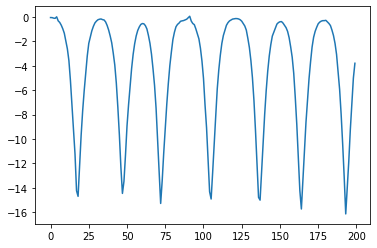

In [18]:
import matplotlib.pyplot as plt
rewards_coll_demo = rewards_coll
# around 25000 trials
plt.plot(rewards_coll_demo)

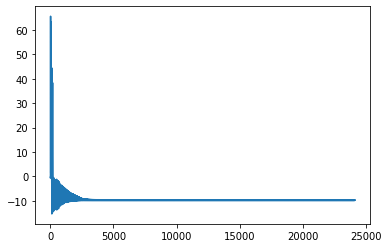

In [16]:
import matplotlib.pyplot as plt
rewards_coll_25000 = rewards_coll
# around 25000 trials
plt.plot(rewards_coll)

## Conclusion
- A critic measures how good the action taken is, "value-based", where as an "Actor" controls how the agent behaves.

## Resources:
1. https://www.freecodecamp.org/news/an-introduction-to-policy-gradients-with-cartpole-and-doom-495b5ef2207f/
1. https://towardsdatascience.com/policy-gradients-in-a-nutshell-8b72f9743c5d
1. https://towardsdatascience.com/reinforcement-learning-w-keras-openai-actor-critic-models-f084612cfd69